
--- Table 2.1: Descriptive Statistics ---
|                 |    count |        mean |      std |         min |         25% |         50% |         75% |         max |
|:----------------|---------:|------------:|---------:|------------:|------------:|------------:|------------:|------------:|
| RowNumber       | 10000.00 |     5000.50 |  2886.90 |        1.00 |     2500.75 |     5000.50 |     7500.25 |    10000.00 |
| CustomerId      | 10000.00 | 15690940.57 | 71936.19 | 15565701.00 | 15628528.25 | 15690738.00 | 15753233.75 | 15815690.00 |
| CreditScore     | 10000.00 |      650.53 |    96.65 |      350.00 |      584.00 |      652.00 |      718.00 |      850.00 |
| Age             | 10000.00 |       38.92 |    10.49 |       18.00 |       32.00 |       37.00 |       44.00 |       92.00 |
| Tenure          | 10000.00 |        5.01 |     2.89 |        0.00 |        3.00 |        5.00 |        7.00 |       10.00 |
| Balance         | 10000.00 |    76485.89 | 62397.41 |        0.00 |      

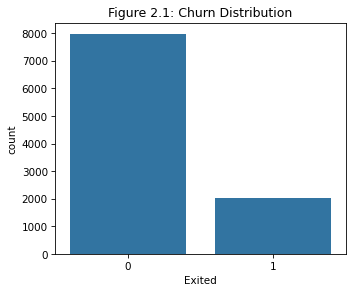

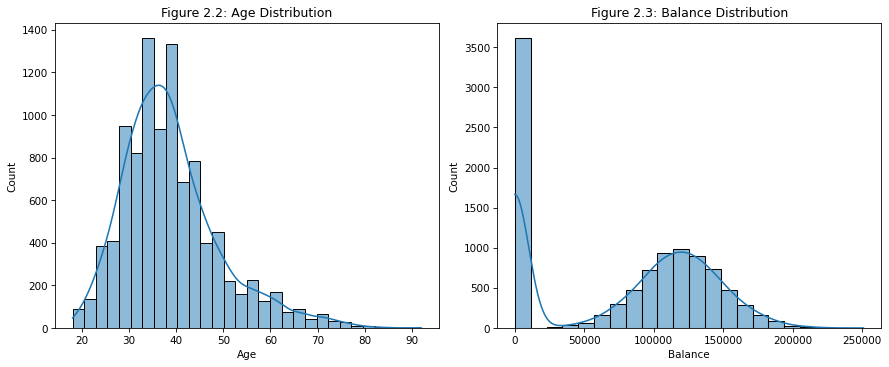

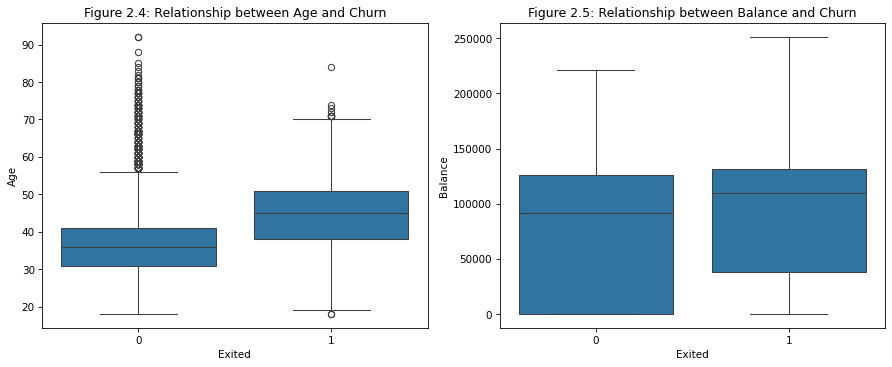

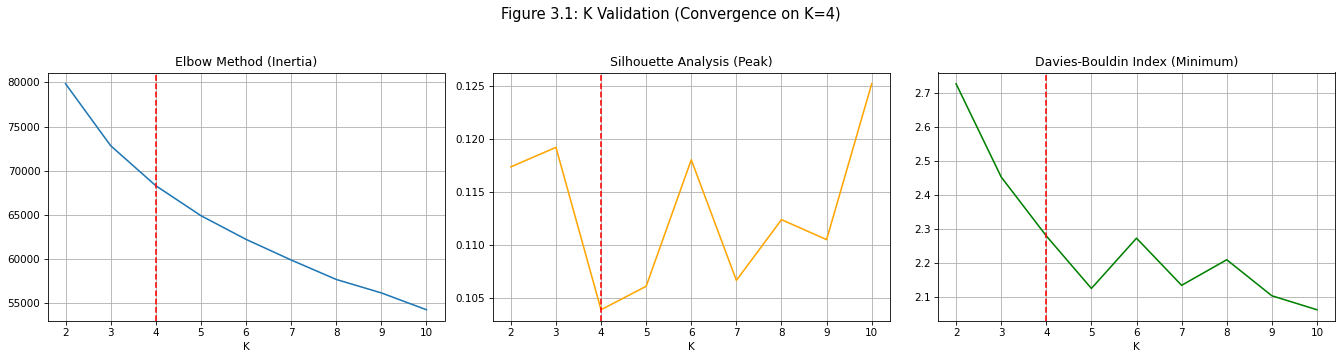

Final K based on metric convergence: K = 4

--- Table 4.1: Churn Rate by Cluster (K-Means) ---
|   Cluster |   Exited |
|----------:|---------:|
|         3 |   32.07% |
|         1 |   19.94% |
|         2 |   15.51% |
|         0 |   13.48% |

--- Table 4.2: Cluster Size and Business Impact ---
|   Cluster |   count |
|----------:|--------:|
|         1 |    2899 |
|         2 |    2476 |
|         3 |    2429 |
|         0 |    2196 |

--- Table 4.3: Mean Cluster Profile ---
|                |        0 |        1 |         2 |         3 |
|:---------------|---------:|---------:|----------:|----------:|
| Exited         |     0.13 |     0.20 |      0.16 |      0.32 |
| IsActiveMember |     0.53 |     0.52 |      1.00 |      0.00 |
| Balance        | 10526.11 | 78715.94 | 105522.14 | 103858.89 |
| NumOfProducts  |     2.15 |     1.50 |      1.28 |      1.26 |
| HasCrCard      |     0.98 |     0.00 |      1.00 |      1.00 |
| Age            |    38.02 |    39.07 |     39.82 |     38.64

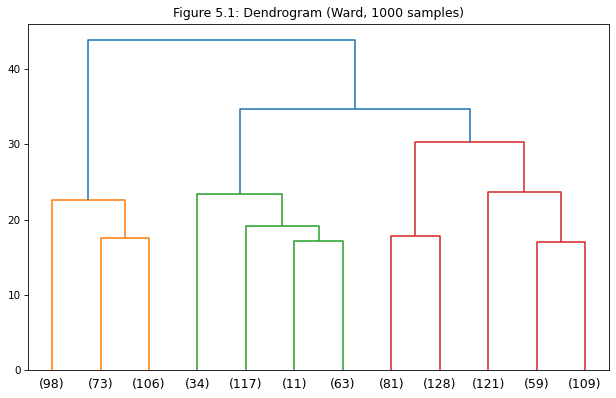

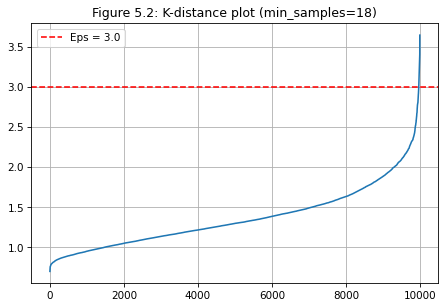


--- Table 5.1: Strategic Comparison Table ---
|                    |   Silhouette |   Risk Cluster |   Loyal Cluster |   Risk Gap |
|:-------------------|-------------:|---------------:|----------------:|-----------:|
| K-Means (Baseline) |       10.39% |         32.07% |          13.48% |  0.185918  |
| Hierarchical       |       11.10% |         24.87% |          18.31% |  0.0655893 |
| DBSCAN             |         nan% |         20.37% |          20.37% |  0         |
| BIRCH              |       10.84% |         21.64% |          19.07% |  0.0256704 |


In [1]:
# =============================================================================
# 1. INTRODUCTION
# =============================================================================


# Importing standard libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Preprocessing and Metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Clustering Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch

# Utilities for DBSCAN and Hierarchical clustering (Dendrograms, Nearest Neighbors)
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage

# GRAPHICS SETTINGS
# Setting plot parameters to ensure readability in the final document
plt.rcParams['figure.figsize'] = (7, 4.5)
plt.rcParams['figure.dpi'] = 75

# Data Loading
df = pd.read_csv('https://raw.githubusercontent.com/erkansirin78/datasets/master/Churn_Modelling.csv')

# =============================================================================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

# Structure and Descriptive Statistical Analysis
# We generate Table 2.1 to inspect the statistical properties of the dataset (mean, std, min, max)
print("\n--- Table 2.1: Descriptive Statistics ---")
descriptive_stats = df.describe()
# Transposed (.T) for better readability
print(descriptive_stats.T.to_markdown(floatfmt=".2f"))


# This calculates the global average churn (approx. 20.37%)
# This value acts as the "Benchmark"
# In Chapter 4, we will compare each cluster's churn rate against this baseline to classify them as "Safe" (<20%) or "Risky" (>20%)
baseline_churn_rate = df['Exited'].mean()
print(f"\nBaseline Churn Rate: {baseline_churn_rate:.2%}\n")



# Visual Analysis

# Shows the class imbalance: ~80% Retained vs ~20% Exited
# This imbalance motivates the use of clustering to find sub-segments rather than just classification
plt.figure(figsize=(5, 4))
ax = sns.countplot(x='Exited', data=df)
ax.grid(False)
plt.title('Figure 2.1: Churn Distribution')
plt.show()



# Univariate Distributions (Age & Balance)
# We inspect 'Age' and 'Balance' as they are key features
# - Age: Shows a roughly normal distribution
# - Balance: Shows a bimodal distribution (many zeros vs active accounts)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Age'], kde=True, bins=30, ax=ax1)
ax1.grid(False)
ax1.set_title('Figure 2.2: Age Distribution')
sns.histplot(df['Balance'], kde=True, ax=ax2)
ax2.grid(False)
ax2.set_title('Figure 2.3: Balance Distribution')
plt.tight_layout()
plt.show()


# Bivariate Analysis (Feature vs Churn)
# These Boxplots visually confirm the correlation between features and Churn:
# - Older customers tend to churn more (higher median age for Exited=1)
# - Customers with higher balances tend to churn more
# This justifies their importance in the subsequent K-Means clustering
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x='Exited', y='Age', data=df, ax=ax1)
ax1.grid(False)
ax1.set_title('Figure 2.4: Relationship between Age and Churn')
sns.boxplot(x='Exited', y='Balance', data=df, ax=ax2)
ax2.grid(False)
ax2.set_title('Figure 2.5: Relationship between Balance and Churn')
plt.tight_layout()
plt.show()


# =============================================================================
# 3. DATA PREPARATION AND K VALIDATION
# =============================================================================

# Preparation: Feature Cleaning and Encoding

# We remove identifiers (RowNumber, CustomerId, Surname) as they introduce noise without predictive value.
# Geography is dropped to focus the analysis strictly on financial behavior and demographics (Age/Gender), rather than regional differences
df_clean = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Geography'], axis=1)


# Encoding Gender: Converting categorical data into binary format (Male=1, Female=0)
# to make it compatible with the distance calculations required by K-Means
df_clean['Gender'] = df_clean['Gender'].map({'Male': 1, 'Female': 0})


# We remove 'Exited' because the algorithm must find groups based on customer behavior
# (Age, Balance, etc.), not by knowing the answer in advance
# We will use 'Exited' only later to calculate the risk for each group
features = df_clean.drop('Exited', axis=1)
target = df_clean['Exited']



# Standardization

# K-Means utilizes Euclidean distance, which is highly sensitive to the scale of variables
# Without scaling, 'Balance' (0-250k) would dominate 'Age' (18-92) or 'NumOfProducts' (1-4)
# We use StandardScaler (Z-score normalization) to give all features equal weight in the algorithm
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
df_scaled = pd.DataFrame(features_scaled, columns=features.columns)



# K Validation

# We test a range of K to find the optimal number of clusters
# We rely on the triangulation of three metrics to ensure robustness, as described in the report
K_range = range(2, 11)
inertia_scores = []     # Elbow Method (measures compactness)
silhouette_scores = []  # Silhouette Score (measures separation and cohesion)
db_scores = []          # Davies-Bouldin (measures similarity between clusters)



for k in K_range:
    # Running KMeans with n_init=10 to avoid local minima
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)

    # Collecting metrics for the current K
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, labels))
    db_scores.append(davies_bouldin_score(df_scaled, labels))




# K Validation Results
# Visualization of the metrics to identify the optimal K
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Figure 3.1: K Validation (Convergence on K=4)', fontsize=14)


# Plot 1: Elbow Method
# We look for the "knee" of the curve where inertia reduction slows down
# Results: The clearest bends are visible at K=4 and K=5
ax1.plot(K_range, inertia_scores)
ax1.set_title('Elbow Method (Inertia)')
ax1.set_xlabel('K')
ax1.axvline(x=4, color='red', linestyle='--')
ax1.grid(True)


# Plot 2: Silhouette Analysis
# We look for a peak
# Results: Peaks observed at K=3 and K=10
# We reject K=3 because it is too general (merges risk groups) and K=10 because it implies "micro-segmentation"
# K=4 is selected as the best operational trade-off
ax2.plot(K_range, silhouette_scores, color='orange')
ax2.set_title('Silhouette Analysis (Peak)')
ax2.set_xlabel('K')
ax2.axvline(x=4, color='red', linestyle='--')
ax2.grid(True)


# Plot 3: Davies-Bouldin Index
# We look for the minimum value
# Results: Minimums found at K=5, K=9, and K=10
# K=4 is chosen via "process of elimination" and business logic despite not being the absolute mathematical minimum
ax3.plot(K_range, db_scores, color='green')
ax3.set_title('Davies-Bouldin Index (Minimum)')
ax3.set_xlabel('K')
ax3.axvline(x=4, color='red', linestyle='--')
ax3.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Strategic Selection and Boundary Analysis

# Since there was no single mathematical convergence, the final selection of K=4 relied on business logic and cluster stability

# 1. Why we rejected K=10 (Micro-segmentation):
# Metrics: Both Silhouette and Davies-Bouldin suggested K=10 was mathematically excellent
# Reason: For a bank, managing 10 segments is operationally inefficient ("Micro-segmentation"). We cannot create and track 10 different retention campaigns effectively

# 2. Why we rejected K=3 (Too General):
# Metrics: Silhouette analysis showed a high score
# Reason: This configuration merged "High Risk" and "Medium Risk" customers into one large group. It hides the specific details needed to predict churn effectively

# 3. Why we rejected K=5 (Redundancy):
# Metrics: Supported by the Davies-Bouldin Index (lower score than K=4)
# Reason: We rejected it because the 5th cluster was just a duplicate sub-group of "Standard Customers" (Cluster 1 - Medium Risk), adding complexity without adding new insight

# Conclusion: Why K=4 is the Winner:
# Supported by the Elbow Method, it creates groups that are distinct enough to be actionable, but simple enough to be managed by the marketing team

OPTIMAL_K = 4
print(f"Final K based on metric convergence: K = {OPTIMAL_K}")


# =============================================================================
# 4. K-MEANS ANALYSIS: BASELINE MODEL AND PROFILING
# =============================================================================

# Model Execution
# We instantiate the K-Means algorithm with the chosen K=4 (validated in Chap 3)
# n_init=10 ensures stability by running the algorithm 10 times with different centroids
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)

# Fit K-Means on normalized data to ensure correct distance metrics
labels_kmeans = kmeans_final.fit_predict(df_scaled)


# Preparation for Profiling
# We map the cluster labels back to the ORIGINAL dataset (df_clean)
# REASON: Business stakeholders need real values (e.g., "Balance = 104k €")
# not Z-scores, to define actionable marketing strategies.
df_profiling = df_clean.copy()
df_profiling['Cluster'] = labels_kmeans


# Execution and Churn Rate Analysis
# We compare the churn rate of each cluster against the Baseline (20.37%)
# GOAL: Determine if the segmentation successfully isolated high-risk groups.
# RESULTS (Table 4.1):
# - Cluster 3 (Critical Risk): 32.07% (Winner)
# - Cluster 0 (Loyal): 13.48%
print("\n--- Table 4.1: Churn Rate by Cluster (K-Means) ---")
churn_per_cluster = df_profiling.groupby('Cluster')['Exited'].mean().sort_values(ascending=False)
print(churn_per_cluster.to_markdown(floatfmt=".2%"))


# Strategic Impact: Size and Priority
# We analyze the distribution to understand the business magnitude of the risk.
# RESULT (Table 4.2):
# Cluster 3 is NOT a niche; it contains 2,429 customers (24.29%).
# This transforms a statistical insight into a top-priority business issue.
print("\n--- Table 4.2: Cluster Size and Business Impact ---")
size_per_cluster = df_profiling['Cluster'].value_counts()
print(size_per_cluster.to_markdown())


# Cluster Profiling
# This table allows us to assign the "Functional Names" described in Section 4.4:
#
# 1. Cluster 3 "Ghost Customers" (Risk: Critical):
#    High Balance (~104k) but Total Inactivity (IsActiveMember=0).
#    Action: Proactive Re-engagement.
#
# 2. Cluster 2 "Active High-Balance" (Risk: Low):
#    High Balance (~105k) but Highly Active.
#    Action: Maintenance/Priority Service.
#
# 3. Cluster 0 "Integrated/Loyal" (Risk: Lowest):
#    Low Balance but High Products (2.15).
#    Action: Loyalty Rewards.
#
# 4. Cluster 1 "Standard No-Card" (Risk: Medium):
#    Average profile, distinct only by lacking a Credit Card.
#    Action: Cross-selling (Credit Cards).

print("\n--- Table 4.3: Mean Cluster Profile ---")
profiling_columns = ['Exited', 'IsActiveMember', 'Balance', 'NumOfProducts', 'HasCrCard', 'Age']
profiling_table = df_profiling.groupby('Cluster')[profiling_columns].mean()
print(profiling_table.T.to_markdown(floatfmt=".2f"))


# =============================================================================
# 5. ADVANCED ANALYSIS AND COMPARATIVE VALIDATION
# =============================================================================

# Methodology: Defining Success Metrics
# Unlike standard tutorials, we do not trust Silhouette alone.
# We introduce the "Risk Gap" as the proxy for Discriminative Power.
# logic: A high gap means the algorithm successfully separated "Bad" from "Good" customers.

def calculate_metrics(labels, df_original_data, df_scaled_data):
    # Check for Noise (-1) used by DBSCAN
    try:
        if -1 in np.unique(labels):
            mask = (labels != -1)
            # Safety check: Need at least 2 clusters to calc Silhouette
            if len(np.unique(labels[mask])) < 2:
                silhouette = np.nan # Algorithm failed to find clusters
            else:
                silhouette = silhouette_score(df_scaled_data[mask], labels[mask])
        else:
            silhouette = silhouette_score(df_scaled_data, labels)
    except ValueError:
        silhouette = np.nan

    # Calculate Churn Rates ignoring noise
    df_temp = df_original_data.copy()
    df_temp['Cluster'] = labels
    churn_rates = df_temp[df_temp['Cluster'] != -1].groupby('Cluster')['Exited'].mean()

    if churn_rates.empty:
        risk_cluster, loyal_cluster, risk_gap = np.nan, np.nan, 0.0
    else:
        risk_cluster = churn_rates.max()
        loyal_cluster = churn_rates.min()
        # The Risk Gap: Our primary KPI for strategic utility
        risk_gap = risk_cluster - loyal_cluster

    return {
        'Silhouette': silhouette,
        'Risk Cluster': risk_cluster,
        'Loyal Cluster': loyal_cluster,
        'Risk Gap': risk_gap
    }

summary_results = {}

# A. K-MEANS (BASELINE)
# The benchmark to beat.
# Result: Risk Gap ~18.59 points (High Utility).
summary_results['K-Means (Baseline)'] = calculate_metrics(labels_kmeans, df_clean, df_scaled)


# B. HIERARCHICAL CLUSTERING
# We use 'Ward' linkage to minimize variance.
# Visualization: Dendrogram on 1,000 samples.
sample_for_dendrogram = df_scaled.sample(n=1000, random_state=42)
linked = linkage(sample_for_dendrogram, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='lastp', p=12)
plt.title('Figure 5.1: Dendrogram (Ward, 1000 samples)')
plt.grid(False)
plt.show()

# Running the model
hier_model = AgglomerativeClustering(n_clusters=OPTIMAL_K, linkage='ward')
labels_hier = hier_model.fit_predict(df_scaled)

# RESULT: Best Silhouette (0.1110) but Strategic Failure.
# Risk Gap is only ~6.56 points. It failed to separate risk effectively.
summary_results['Hierarchical'] = calculate_metrics(labels_hier, df_clean, df_scaled)


# C. DBSCAN (Density-Based)
# Parameters: Eps=3.0 (from Elbow Plot), Min_Samples=18 (2*Features).
MIN_SAMPLES = df_scaled.shape[1] * 2

# K-distance plot to find Epsilon
nn = NearestNeighbors(n_neighbors=MIN_SAMPLES)
neighbors_fit = nn.fit(df_scaled)
distances, _ = neighbors_fit.kneighbors(df_scaled)
k_distances = np.sort(distances[:, MIN_SAMPLES-1])

plt.figure(figsize=(7, 4.5))
plt.plot(k_distances)
plt.title(f'Figure 5.2: K-distance plot (min_samples={MIN_SAMPLES})')
plt.axhline(y=3.0, color='red', linestyle='--', label='Eps = 3.0')
plt.legend()
plt.grid(True)
plt.show()

OPTIMAL_EPS = 3.0
dbscan_model = DBSCAN(eps=OPTIMAL_EPS, min_samples=MIN_SAMPLES)
labels_dbscan = dbscan_model.fit_predict(df_scaled)

# RESULT: Total Failure.
# Found only 1 cluster containing everyone (or mostly noise).
# Risk Gap = 0. Risk profiles are too intermingled for density-based separation.
summary_results['DBSCAN'] = calculate_metrics(labels_dbscan, df_clean, df_scaled)


# D. BIRCH
# Designed for speed/efficiency.
birch_model = Birch(n_clusters=OPTIMAL_K)
labels_birch = birch_model.fit_predict(df_scaled)

# RESULT: Strategic Failure.
# Similar to Hierarchical, it grouped customers around the average.
# Risk Gap ~2.57 points (Negligible).
summary_results['BIRCH'] = calculate_metrics(labels_birch, df_clean, df_scaled)



# Conclusions

# We print the Comparison Table to declare the winner.
# FINAL CONCLUSION (Section 5.3):
# - K-Means is the ONLY strategically correct choice.
# - It provides a Risk Gap of ~19 points vs ~6 points for Hierarchical.
# - The "Best Metric" (Silhouette) did not correspond to the "Best Business Solution".
print("\n--- Table 5.1: Strategic Comparison Table ---")
df_summary = pd.DataFrame.from_dict(summary_results, orient='index')
print(tabulate(
    df_summary,
    headers='keys',
    tablefmt='pipe',
    floatfmt=('.4f', '.2%', '.2%', '.2%')
))